In this work we will resolve the problem of Multi Label Classification. For each id we will predict the probability of belonging to each of 14 labels.

We will split the analysis into following parts:

- Exploratory analysis: observation of the raw data, check the types, check the presence of NaNs, filling missing values, encoding of categorical columns.
- Exploratory analysis (continue): application of dimensional reduction technics (PCA, TSNE), check the number of appearence of each label in visualisation of  data cloud, barplots to show the number of apperaarances of objects in each label.
- Feature importance: reduce the number of used features by taking only the most decisive ones using 0.1 threshold.
- Baseline: try the model using the raw data.
- Improved model: try to improve the model metrics (log_loss, accuracy) using just the list of important selected features, tune the Classifier hyperparameters, try to use OneVsRestClassifier dedicated to this type of problem, use principal components got from PCA as features in model.
- Predict the test data. Get the matrice of probabilities of belongings to each label.

In [2]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt

import scipy.stats as stats
import seaborn as sns
from collections import Counter
import re
import glob
import datetime
from datetime import datetime
from dateutil import parser
from pprint import pprint

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import precision_recall_curve, classification_report, roc_curve, log_loss, accuracy_score

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn import metrics

import math
from mpl_toolkits.mplot3d import Axes3D

from sklearn.utils import resample

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import os 

C:\Users\mvideo\Anaconda3-1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Define models
def validation_models(models,X,y):
    model_names,means,stds = [],[],[]
    for name, model in models:
         #cross validation among models, score based on accuracy
         cv_results = cross_val_score(model,X,y, scoring='accuracy', cv=kfold )
         #print("\n"+name)
         model_names.append(name)
         #print("Result: "+str(cv_results))
         #print("Mean: " + str(cv_results.mean()))
         #print("Standard Deviation: " + str(cv_results.std()))
         means.append(cv_results.mean())
         stds.append(cv_results.std())
    return model_names,means,stds

def apply_models(models,X_train, X_test, y_train, y_test):
    for name, model in models:
        model.fit(X_train,y_train)
        preds = model.predict(X_test)
        print(name+' confusion matrix')
        print(pd.crosstab(y_test, preds, rownames=['Real'], colnames=['Predicted']))
        print('--------------------------------------------------------------------')
    return models

# Plot accuracy
def plot_accuracy(models,means,stds):
    x_loc = np.arange(len(models))
    width = 0.5
    fig = plt.figure(figsize=(10,6))
    models_graph = plt.bar(x_loc, means, width, yerr=stds)
    plt.ylabel('Accuracy')
    plt.title('Scores by models')
    plt.xticks(x_loc, model_names,rotation=90) # models name on x-axis

    #add valve on the top of every bar
    def addLabel(rects):
        for rect in rects:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
            '{0:.3f}'.format(height), ha='center',
            va='bottom')

    addLabel(models_graph)

    plt.show()

def ROC_curve(models,X_test, y_test):
    for name, model in models:
        # ROC curve
        sns.set(font_scale = 1.5)
        sns.set_color_codes("muted")
        plt.figure(figsize=(10,8))
        #print(model.predict_proba(y_test).values.reshape(-1, 1))
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1], pos_label=1)
        lw = 2
        plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
        plt.plot([0, 1], [0, 1])
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve: '+name)
        plt.savefig("ROC.png")
        plt.show()
        
def ACP_vis(X, color='g'):
    # CPA
    pca = PCA(n_components=3)
    X_reduced = pca.fit_transform(X)
    print('Projecting %d-dimensional data to 3D' % X.shape[1])
    fig = plt.figure()
    #ax3 = plt.axes()
    ax3 = Axes3D(fig)
    #ax3.figure(figsize=(12,10))
    ax3.scatter(X_reduced[:, 0], X_reduced[:, 1],X_reduced[:, 2], c=color, 
                edgecolor='none', alpha=0.7, s=40,
                cmap=plt.cm.get_cmap('nipy_spectral', 10),
                marker='o')
    #ax3 = sns.regplot(x=X_reduced[:, 0], y=X_reduced[:, 1], color=color)
    
    plt.show()
    #ax3.colorbar()
    #ax3.title('MNIST. PCA projection')
#ACP_vis(X_red, color)

def TSNE_vis(X, color='g'):
    #TSNE
    tsne = TSNE(random_state=17)
    X_reduced = tsne.fit_transform(X)
    print('Projecting %d-dimensional datato 2D' % X.shape[1])
    fig = plt.figure()
    ax3 = plt.axes()
    #ax3.figure(figsize=(12,10))
    ax3.scatter(X_reduced[:, 0], X_reduced[:, 1], c=color, 
                edgecolor='none', alpha=0.7, s=40,
                cmap=plt.cm.get_cmap('nipy_spectral', 10))
    plt.show()
    
def SVM_model(X_train, y_train, X_test, y_test,kernel = 'rbf'):
    model = SVC(kernel ='rbf', probability=True)
    model.fit(X_train, y_train)
    print(model)
    # make predictions
    expected = y_test
    predicted = model.predict(X_test)
    # summarize the fit of the model
    print(metrics.classification_report(expected, predicted))
    print(metrics.confusion_matrix(expected, predicted))
    ROC_curve(model, X_test, y_test)

In [4]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [121]:
#%%Read data 
dflabels = pd.read_csv(r'C:\Users\mvideo\Documents\Fax\Test_Active_Matrix\problem_labels.csv',
                       sep = ',', header = 0, index_col=False, low_memory=False)
dftrain = pd.read_csv(r'C:\Users\mvideo\Documents\Fax\Test_Active_Matrix\problem_train.csv',
                      sep = ',', header = 0, index_col=False, low_memory=False)
dftest = pd.read_csv(r'C:\Users\mvideo\Documents\Fax\Test_Active_Matrix\problem_test.csv',
                     sep = ',', header = 0, index_col=False, low_memory=False)


# Exploratory Data Analysis

In [117]:
# Look at train data
print(dftrain.columns)
print(len(dftrain.columns))
print('train shape: ', dftrain.shape)
print('test shape: ', dftest.shape)
# Presence of NaN, number of NaN columns/ rows
dftrain.head()

Index(['id', 'release', 'n_0000', 'n_0001', 'n_0002', 'n_0003', 'n_0004',
       'n_0005', 'n_0006', 'n_0007',
       ...
       'c_1368', 'c_1369', 'c_1370', 'c_1371', 'c_1372', 'c_1373', 'c_1374',
       'c_1375', 'c_1376', 'c_1377'],
      dtype='object', length=1379)
1379
train shape:  (8000, 1379)
test shape:  (2000, 1379)


,id,release,n_0000,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,...,c_1368,c_1369,c_1370,c_1371,c_1372,c_1373,c_1374,c_1375,c_1376,c_1377
0,11193,a,NaN,NaN,0.025449,NaN,NaN,0.368421,NaN,NaN,...,NaN,NaN,NaN,NaN,a,NaN,q,NaN,NaN,NaN
1,11382,a,NaN,NaN,0.031297,NaN,NaN,0.315789,NaN,NaN,...,NaN,NaN,a,NaN,a,NaN,NaN,NaN,NaN,NaN
2,16531,a,NaN,NaN,0.024475,NaN,NaN,0.342105,NaN,NaN,...,NaN,NaN,a,NaN,a,NaN,b,NaN,NaN,NaN
3,1896,a,NaN,NaN,0.041694,NaN,NaN,0.447368,NaN,NaN,...,NaN,NaN,NaN,NaN,a,NaN,NaN,NaN,NaN,NaN
4,18262,c,NaN,NaN,0.038120,NaN,NaN,0.315789,NaN,NaN,...,NaN,NaN,b,NaN,a,NaN,a,NaN,NaN,NaN


### Examine Missing Values

In [118]:
# Missing values statistics
missing_values = missing_values_table(dftrain)
missing_values.head(20)

Your selected dataframe has 1379 columns.
There are 1347 columns that have missing values.


,Missing Values,% of Total Values
c_1129,8000,100.0
c_0710,8000,100.0
c_0529,8000,100.0
c_0902,8000,100.0
c_1281,8000,100.0
c_1277,8000,100.0
c_0693,8000,100.0
c_0959,8000,100.0
c_1257,8000,100.0
c_0596,8000,100.0


In [122]:
# Check the column has only NaNs 

count = 0
dftrp = dftrain
dftp = dftest
# Drop columns filled only with NaN
for col in dftrain.columns:
    #Drop the columns with NaNs percentage greater then 90% of column shape 
    if dftrain[col].value_counts().sum() <= 0.2*dftrain.shape[0]:
        dftrp.drop(col, inplace=True, axis=1)
        dftp.drop(col, inplace=True, axis=1)
        count = count +1
        
# Number of empty columns
print('number of empty columns: ',count)

number of empty columns:  1044


In [123]:
# Check the part of NaNs in the rest columns. 
missing_values = missing_values_table(dftrp)
missing_values.head(20)

Your selected dataframe has 335 columns.
There are 303 columns that have missing values.


,Missing Values,% of Total Values
c_0430,6399,80.0
o_0129,6385,79.8
c_0949,6383,79.8
c_1231,6379,79.7
n_0051,6378,79.7
c_0724,6369,79.6
n_0028,6369,79.6
c_1243,6334,79.2
c_0658,6329,79.1
c_0926,6328,79.1


In [124]:
# Check shape after drop of empty columns
print(dftrp.columns)
print(len(dftrp.columns))
print('train shape: ', dftrp.shape)
print('test shape: ', dftp.shape)
dftrp.head()

Index(['id', 'release', 'n_0002', 'n_0005', 'n_0012', 'n_0019', 'n_0028',
       'n_0034', 'n_0038', 'n_0039',
       ...
       'c_1333', 'c_1335', 'c_1343', 'c_1347', 'c_1348', 'c_1361', 'c_1363',
       'c_1372', 'c_1374', 'c_1377'],
      dtype='object', length=335)
335
train shape:  (8000, 335)
test shape:  (2000, 335)


,id,release,n_0002,n_0005,n_0012,n_0019,n_0028,n_0034,n_0038,n_0039,...,c_1333,c_1335,c_1343,c_1347,c_1348,c_1361,c_1363,c_1372,c_1374,c_1377
0,11193,a,0.025449,0.368421,0.292683,0.0,NaN,0.223881,0.193548,NaN,...,e,w,b,NaN,b,e,b,a,q,NaN
1,11382,a,0.031297,0.315789,0.243902,0.0,NaN,0.104478,0.177419,NaN,...,e,q,b,NaN,b,e,b,a,NaN,NaN
2,16531,a,0.024475,0.342105,0.304878,0.0,NaN,0.119403,0.290323,NaN,...,e,u,a,NaN,b,c,a,a,b,NaN
3,1896,a,0.041694,0.447368,0.207317,0.0,NaN,0.149254,0.370968,NaN,...,NaN,w,a,NaN,b,g,a,a,NaN,NaN
4,18262,c,0.038120,0.315789,0.219512,0.0,NaN,0.074627,0.177419,0.3125,...,e,b,b,d,b,e,b,a,a,NaN


### Column Types

In [125]:
# Number of each type of column
dftrp.dtypes.value_counts()

object     265
float64     61
int64        9
dtype: int64

265 categorical columns. This means we cannot use one-hot encoding for their transformation, because the number of columns will explode. Use just label-encoding.

### Filling raws with NaNs
Lets fill empty cells in numerical columns with the mean values for each column.

In [126]:
# Iterate through the columns
for col in dftrp:
    if (dftrp[col].dtype == 'float64')|(dftrp[col].dtype == 'int64'):
        dftrp[col] = dftrp[col].fillna(value = dftrp[col].mean())
        dftp[col] = dftp[col].fillna(value = dftp[col].mean())

In [127]:
# Check presence of NaNs
print('train dataset NaNs any: ', dftrp.isnull().values.any())
print('test dataset NaNs any: ', dftrp.isnull().values.any())

train dataset NaNs any:  True
test dataset NaNs any:  True


In [128]:
# Checkpoint
dftrp.to_csv(r'C:\Users\mvideo\Documents\Fax\Test_Active_Matrix\dftrp.csv')
dftp.to_csv(r'C:\Users\mvideo\Documents\Fax\Test_Active_Matrix\dftp.csv')

### Encoding of categorical variables

In [129]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in dftrp:
    if dftrp[col].dtype == 'object':
        # Transform both training and testing data
        dftrp[col] = le.fit_transform(dftrp[col].astype(str))
        dftp[col] = le.fit_transform(dftp[col].astype(str))
        # Keep track of how many columns were label encoded
        le_count += 1
        
print('%d columns were label encoded.' % le_count)

265 columns were label encoded.


In [130]:
print('Training Features shape: ', dftrp.shape)
print('Testing Features shape: ', dftp.shape)

Training Features shape:  (8000, 335)
Testing Features shape:  (2000, 335)


In [131]:
# Check presence of NaNs
print('train dataset NaNs any: ', dftrp.isnull().values.any())
print('test dataset NaNs any: ', dftrp.isnull().values.any()

train dataset NaNs any:  False
test dataset NaNs any:  False


### Check Labels

In [132]:
print(dflabels.columns[1:])
print('Training labels shape: ', dflabels.shape)

Index(['service_a', 'service_b', 'service_c', 'service_d', 'service_e',
       'service_f', 'service_g', 'service_h', 'service_i', 'service_j',
       'service_k', 'service_l', 'service_m', 'service_n'],
      dtype='object')
Training labels shape:  (8000, 15)


In [133]:
# Look at labels
print(dflabels.dtypes)
print(len(dflabels.columns))
print('shape: ', dflabels.shape)

# Size of each class
print(dflabels[list(dflabels.columns[1:])].sum())
print(dflabels[list(dflabels.columns[1:])].sum().sum())

id           int64
service_a    int64
service_b    int64
service_c    int64
service_d    int64
service_e    int64
service_f    int64
service_g    int64
service_h    int64
service_i    int64
service_j    int64
service_k    int64
service_l    int64
service_m    int64
service_n    int64
dtype: object
15
shape:  (8000, 15)
service_a    3777
service_b    2626
service_c    2093
service_d     136
service_e     431
service_f     233
service_g     415
service_h    2376
service_i     129
service_j    6786
service_k    6256
service_l     864
service_m     709
service_n    1424
dtype: int64
28255


In [134]:
# Add target back in to the data
# Merge 2 dataframes
dftrain2 = dftrp.merge(dflabels, on=['id'],how='inner')

In [135]:
print('Joined dataframe shape: ', dftrain2.shape)

Joined dataframe shape:  (8000, 349)


Each Id can belong to multiple labels.

# Exploratory Data Analysis (continue)

### PCA, TSNE

Create checkpoint

In [136]:
# Checkpoint
dftrain2.to_csv(r'C:\Users\mvideo\Documents\Fax\Test_Active_Matrix\dftrain2.csv')

In [11]:
dftrain2 = pd.read_csv(r'C:\Users\mvideo\Documents\Fax\Test_Active_Matrix\dftrain2.csv')

In [137]:
dftrain2.columns

Index(['id', 'release', 'n_0002', 'n_0005', 'n_0012', 'n_0019', 'n_0028',
       'n_0034', 'n_0038', 'n_0039',
       ...
       'service_e', 'service_f', 'service_g', 'service_h', 'service_i',
       'service_j', 'service_k', 'service_l', 'service_m', 'service_n'],
      dtype='object', length=349)

Projecting 349-dimensional data to 3D


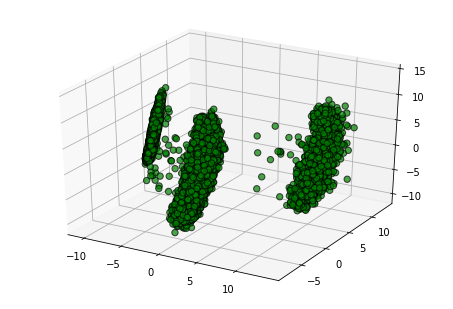

In [138]:
#%% Visualisation PCA, TSNE 
X_red = StandardScaler().fit_transform(dftrain2)
ACP_vis(X_red)

In [59]:
#TSNE (X_red)
tsne = TSNE(random_state=17)
X_reduced = tsne.fit_transform(X_red)

Projecting 448-dimensional datato 2D  on  service_a


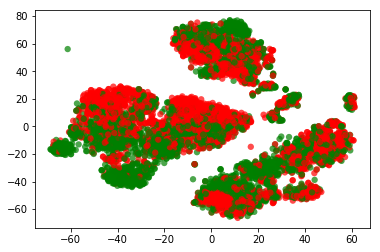

Projecting 448-dimensional datato 2D  on  service_b


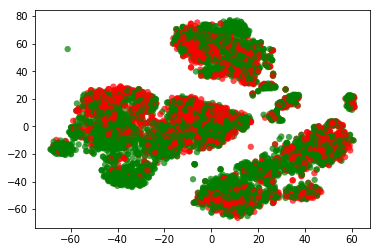

Projecting 448-dimensional datato 2D  on  service_c


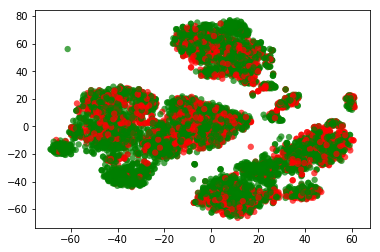

Projecting 448-dimensional datato 2D  on  service_d


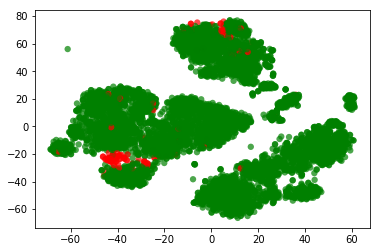

Projecting 448-dimensional datato 2D  on  service_e


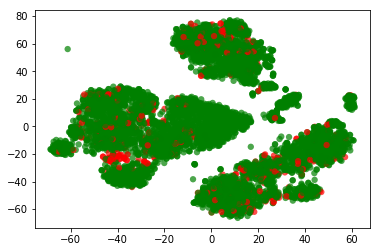

Projecting 448-dimensional datato 2D  on  service_f


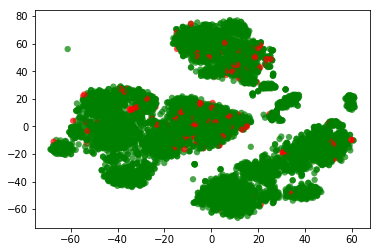

Projecting 448-dimensional datato 2D  on  service_g


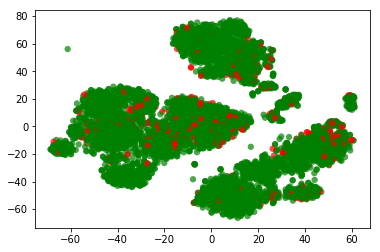

Projecting 448-dimensional datato 2D  on  service_h


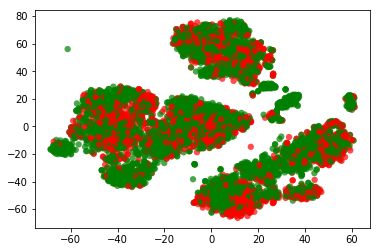

Projecting 448-dimensional datato 2D  on  service_i


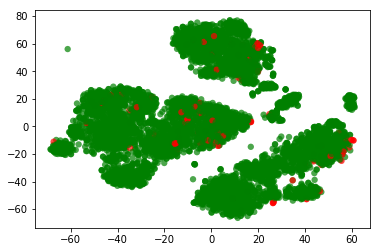

Projecting 448-dimensional datato 2D  on  service_j


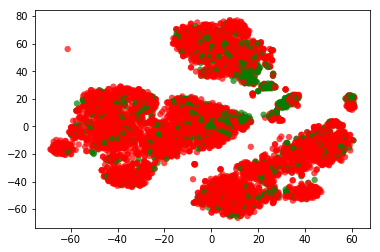

Projecting 448-dimensional datato 2D  on  service_k


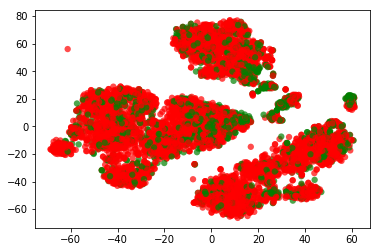

Projecting 448-dimensional datato 2D  on  service_l


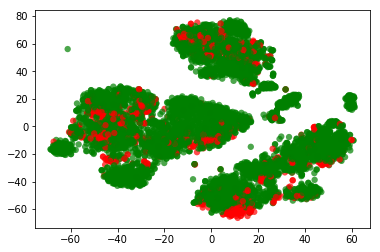

Projecting 448-dimensional datato 2D  on  service_m


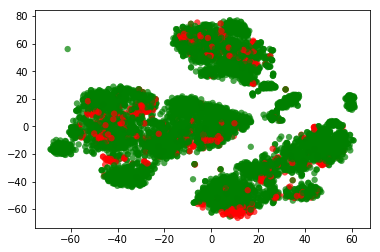

Projecting 448-dimensional datato 2D  on  service_n


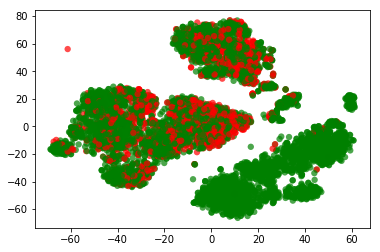

In [66]:
# Visualisation
for i in range(1,len(dflabels.columns)):
    color =  ['r' if x==1 else 'g' for x in dflabels[dflabels.columns[i]]]
    print('Projecting %d-dimensional datato 2D' % X_red.shape[1], ' on ', dflabels.columns[i])
    fig = plt.figure()
    ax3 = plt.axes()
    ax3.scatter(X_reduced[:, 0], X_reduced[:, 1], c=color, 
                edgecolor='none', alpha=0.7, s=40,
                cmap=plt.cm.get_cmap('nipy_spectral', 10))
    plt.show()

After have done TSNE we can notice first that in general the classes for each label are mixed among clusters. Service_n label appears only in 2 of 3 clusters. Belonging to service_k/j is dominating for the most part of examples. Now we will look at the number of occurences of examples in each release.

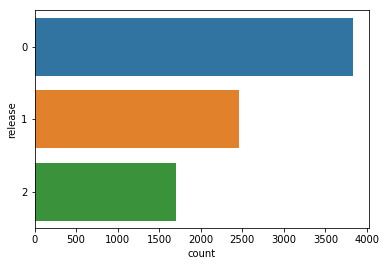

In [139]:
plt.figure(1)
ax1 = sns.countplot(y = 'release', data=dftrain2)
plt.show()

Look at the number of occurences of examples in each class

In [140]:
list(dflabels[list(dflabels.columns[1:])].sum().index)

['service_a',
 'service_b',
 'service_c',
 'service_d',
 'service_e',
 'service_f',
 'service_g',
 'service_h',
 'service_i',
 'service_j',
 'service_k',
 'service_l',
 'service_m',
 'service_n']

service_a    3777
service_b    2626
service_c    2093
service_d     136
service_e     431
service_f     233
service_g     415
service_h    2376
service_i     129
service_j    6786
service_k    6256
service_l     864
service_m     709
service_n    1424
dtype: int64


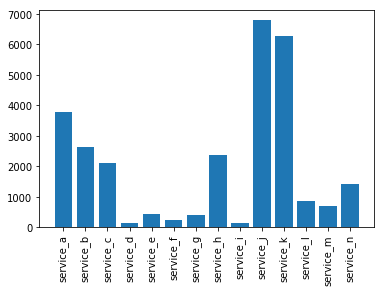

In [141]:
print(dflabels[list(dflabels.columns[1:])].sum())
plt.figure(1)
temp = dflabels[list(dflabels.columns[1:])].sum().to_frame(name='numbers')
p = plt.bar(np.arange(14), list(dflabels[list(dflabels.columns[1:])].sum()))
plt.xticks(np.arange(14), list(dflabels[list(dflabels.columns[1:])].sum().index), rotation=90)
plt.show()

Here we can say that service_j/ k have the highest number of appearences. Service_d/e/f/g/i has the smallest number of appearences.

# Feature Importance

In [142]:
Xtrain = dftrp[dftrp.columns[1:]]
ytrain = dflabels[dflabels.columns[1:]]
Xtest = dftp[dftp.columns[1:]]
features = dftrp.columns[1:]

In [143]:
print('Training Features shape: ', Xtrain.shape)
print('Test Features shape: ', Xtest.shape)
print('Targets shape: ', ytrain.shape)

Training Features shape:  (8000, 334)
Test Features shape:  (2000, 334)
Targets shape:  (8000, 14)


In [144]:
# Check presence of NaNs
print('train dataset NaNs any: ', Xtrain.isnull().values.any())
print('test dataset NaNs any: ', Xtest.isnull().values.any())

train dataset NaNs any:  False
test dataset NaNs any:  False


In this part of analysis we will use RandomForestClassifier for baseline as well as for different version of improvements. Accordiing to sklearn documentation we can use quite restricted list of models for resolving of multilabel classification problem (http://scikit-learn.org/stable/modules/multiclass.html). One of such models is RandomForestClassifier. We will use it also because of high robustness of this method.

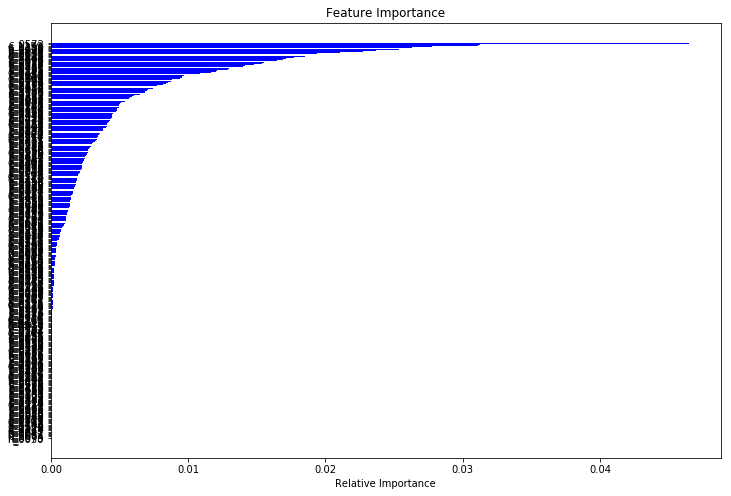

In [145]:
clf = RandomForestClassifier(bootstrap = True, max_depth = 4, max_features = 8, min_samples_leaf = 4,
                                   min_samples_split = 4, n_estimators = 1000)
clf.fit(Xtrain, ytrain)

importances = clf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,8))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()
#sorted(list(zip(Xtrain,clf.feature_importances_)))

In [146]:
dict_feat_imp = dict(list(zip(Xtrain,clf.feature_importances_)))

sorted(dict_feat_imp.items(), key=lambda x: x[1], reverse = True)

[('c_0572', 0.046463292517283143),
 ('c_1259', 0.031253055169435627),
 ('c_1190', 0.031128422630101685),
 ('n_0108', 0.027755081827616983),
 ('n_0078', 0.026329741171535061),
 ('c_1029', 0.02535528890329207),
 ('c_1109', 0.023706308473524722),
 ('c_1033', 0.022757625729205717),
 ('c_0835', 0.021065307307500638),
 ('n_0002', 0.019416511242669635),
 ('c_1225', 0.018608954976089189),
 ('c_1239', 0.018502338294954512),
 ('c_1003', 0.017694020427676007),
 ('c_0794', 0.017113659090837608),
 ('c_0920', 0.016923247411628456),
 ('c_0952', 0.016466443228334942),
 ('n_0012', 0.015543197747478532),
 ('c_1377', 0.015352338761122613),
 ('c_0810', 0.014767096280990053),
 ('c_0787', 0.014163901854841003),
 ('c_0403', 0.014007030270153827),
 ('c_0785', 0.012945108142611444),
 ('c_1235', 0.012918926006690323),
 ('o_0141', 0.012062216751096548),
 ('c_0434', 0.012001149853566755),
 ('c_0953', 0.011675924495790364),
 ('c_1053', 0.010846630668854882),
 ('c_1043', 0.0096803221568747492),
 ('c_1169', 0.009542

In [147]:
sorted_feat_imp = sorted(dict_feat_imp.items(), key=lambda x: x[1], reverse = True)
sorted_feat_imp.index(('n_0071', 0.0042914505895421361))
imp_feat = [x[0] for x in sorted_feat_imp[:sorted_feat_imp.index(('n_0071', 0.0042914505895421361))]]

In [151]:
print('Number of important features: ', len(imp_feat))

Number of important features:  65


Let's take the list of features with the treshold 10% of maximum importance: 0.0465...0.0043  (c_0572...n_0071)

# Baseline

For baseline take raw data with all features. In this part we will use RandomForestClassifier with the parameters put manually (number of trees = 1000, max_depth=4).

In [149]:
kfold = KFold(n_splits=3)
cv_results = cross_val_score(clf,Xtrain,ytrain, scoring='accuracy', cv=kfold )

In [150]:
print('accuracy: ', cv_results.mean())

accuracy:  0.25412614871


# Improved model
Let's take the raw data with just important features. Here we are still using RandomForestClassifier with default parameters.

In [91]:
kfold = KFold(n_splits=3)
cv_results = cross_val_score(clf,Xtrain[imp_feat],ytrain, scoring='accuracy', cv=kfold )
print('accuracy: ', cv_results.mean())

accuracy:  0.264126352173


Improvement by 1.2%. Now we will look the both metrics: log_loss and accuracy.  Let's take the data with important features.

### Tune RandomForest Hyperparameters

In [152]:
# Checkpoint
Xtrain[imp_feat].to_csv(r'C:\Users\mvideo\Documents\Fax\Test_Active_Matrix\train_imp.csv')
ytrain.to_csv(r'C:\Users\mvideo\Documents\Fax\Test_Active_Matrix\train_target_imp.csv')

In [5]:
Xtrain_temp = pd.read_csv(r'C:\Users\mvideo\Documents\Fax\Test_Active_Matrix\train_imp.xlsx')
ytrain = pd.read_csv(r'C:\Users\mvideo\Documents\Fax\Test_Active_Matrix\train_target_imp.xlsx')

In [154]:
Xtrain1, Xval, ytrain1, yval = train_test_split(Xtrain[imp_feat], ytrain, test_size=0.2, random_state=42)

In [155]:
print('Training Features shape: ', Xtrain1.shape)
print('Training Target shape: ', ytrain1.shape)

Training Features shape:  (6400, 65)
Training Target shape:  (6400, 14)


In [156]:
#%% Grid Search
clf = RandomForestClassifier(bootstrap = True, max_depth = 4, max_features = 8, min_samples_leaf = 4,
                                   min_samples_split = 4, n_estimators = 1000)
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 50],
    'max_features': ['auto', 'sqrt'],
    #'max_features': [ 4, 6, 8, 10],
    'min_samples_leaf': [3, 4],
    #'min_samples_split': [4, 5],
    'n_estimators': [100, 500]
}
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(Xtrain1, ytrain1)
grid_search.best_params_

grid_search.predict_proba(Xval)[0:10]

# Evaluate Classifier
# Create a confusion matrix 
preds = grid_search.predict(Xval)
try:
    print(pd.crosstab(yval, preds, rownames=['Real'], colnames=['Predicted']))
except:
    print('')

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  8.4min finished


In [157]:
print('accuracy: ', accuracy_score(yval, preds, normalize=True, sample_weight=None))
print('log_loss: ', log_loss(yval, preds, normalize=True, sample_weight=None, labels=None))

accuracy:  0.271875
log_loss:  46.7213348403


Improvement by 1.8% with respect to Baseline.

### Try Multilabel Classifier

Let's try multilabel learning. Here we will use OneVsRestClassifier dedicated for this type of problem. As the model we will use already tuned RandomForestClassifier on normalized data.

In [159]:
print(Xtrain1.shape)

(6400, 65)


In [97]:
from sklearn.multiclass import OneVsRestClassifier
# Normalize the data
Xtrain1_red = StandardScaler().fit_transform(Xtrain1)
Xval_red = StandardScaler().fit_transform(Xval)
# Create and train the model
classif = OneVsRestClassifier(grid_search)
classif.fit(Xtrain1_red, ytrain1)
preds = classif.predict(Xval)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  3.0min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.2min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.3min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.8min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.2min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.8min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.3min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.1min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.9min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.3min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.2min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.1min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.7min finished


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.8min finished


In [99]:
print('accuracy: ', accuracy_score(yval, preds, normalize=True, sample_weight=None))
print('log_loss: ', log_loss(yval, preds, normalize=True, sample_weight=None, labels=None))

accuracy:  0.055625
log_loss:  51.6478282182


OneVsRestClassifier don't give us the increase in accuracy as was expected. This rests to be precised.

### Use results of ACP as features in tuned RandomForestClassifier
In this part we will use the principal components PC1, PC2, PC3 of ACP as inputs in the tuned RandomForestClassifier. Then we will compare the accuracy with it and with the Baseline.

In [160]:
# Pretreat the data
Xtrain1_red = StandardScaler().fit_transform(Xtrain1)
Xval_red = StandardScaler().fit_transform(Xval)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(Xtrain1_red)
Xval_pca = pca.fit_transform(Xval_red)

# Define Classifier
grid_search_pca = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search_pca.fit(X_pca, ytrain1)
preds = grid_search_pca.predict(Xval_pca)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  8.4min finished


In [161]:
print('accuracy: ', accuracy_score(yval, preds, normalize=True, sample_weight=None))
print('log_loss: ', log_loss(yval, preds, normalize=True, sample_weight=None, labels=None))

accuracy:  0.2125
log_loss:  54.6192123462


The accuracy has been reduced by 4% with respect to Baseline. So finally for prediction we will use the tuned RandomForestClassifier hust with the list of important features.

# Predict the test data

In [162]:
print('Test Features shape: ', Xtest[imp_feat])
print(Xtest[imp_feat].isnull().values.any())

(2000, 65)
False


In [198]:
#Predict
preds_proba = grid_search.predict_proba(Xtest[imp_feat])

In [199]:
dict_temp = {}
for (service,service_name) in zip(preds_proba,dflabels.columns[1:]):
    dict_temp[service_name] = [x[1] for x in service]

In [200]:
# Convert probas to DataFrame
df_preds_proba = pd.DataFrame(dict_temp)
df_preds_proba.head()
print(df_preds_proba.shape)
df_preds_proba['id'] = dftp['id']

# change order of columns in dataframe
cols = list(sorted(df_preds_proba.columns.values))
df_preds_proba = df_preds_proba[cols]

(2000, 14)


In [201]:
df_preds_proba.head()

,id,service_a,service_b,service_c,service_d,service_e,service_f,service_g,service_h,service_i,service_j,service_k,service_l,service_m,service_n
0,7957,0.852594,0.538198,0.332483,0.024208,0.116175,0.036851,0.043565,0.190288,0.030612,0.882401,0.843074,0.069215,0.058123,0.160340
1,693,0.190695,0.142133,0.137703,0.086939,0.109408,0.006038,0.022747,0.227802,0.003698,0.911225,0.861202,0.076166,0.067397,0.163042
2,15558,0.507663,0.435405,0.328002,0.006815,0.062649,0.031693,0.039321,0.354548,0.027479,0.871016,0.811835,0.164358,0.142037,0.244173
3,15614,0.386175,0.308333,0.310681,0.059085,0.091905,0.035312,0.073732,0.538345,0.028125,0.834144,0.810340,0.291445,0.238827,0.339589
4,8149,0.622875,0.446764,0.378691,0.000500,0.026160,0.053728,0.109185,0.346282,0.014697,0.708750,0.589662,0.044171,0.031766,0.184491


In [203]:
# Write to file 
df_preds_proba.to_csv(r'C:\Users\mvideo\Documents\Fax\Test_Active_Matrix\problem_test_labels.csv')

# Conclusion

We have created the model which is capable to predict correctly 27% of object (log_loss = 46.7). The performance can be improved by the following means:

- Application of OneVsRestClassifier (rest to be precised);
- Application of ensemble of models dedicated to the Multi Label Classification problem;
- Application of boosting algorithms (Adaboost, XGBoost).